<a href="https://colab.research.google.com/github/AbdullahNasser98/Chest-XRAY/blob/master/Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"abdullahnasser","key":"cf934485d641c4759dcc24e8c3a3a170"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 files		    kaggle.json			    sample_data
'kaggle (1).json'   labeled-chest-xray-images.zip


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('labeled-chest-xray-images.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [ ]:
train_dir = '/content/files/chest_xray/train/'
test_dir = '/content/files/chest_xray/test/'

Read training images





In [ ]:
# Visualize Image before Image Augmentation
train_pneumonia_img = glob(train_dir+'/PNEUMONIA/*.jpeg') 
train_normal_img = glob(train_dir+'/NORMAL/*.jpeg') 

In [ ]:
pneumonia = np.asarray(cv.imread(train_pneumonia_img[0]))
normal = np.asarray(cv.imread(train_normal_img[0]))

(872, 1160, 3)


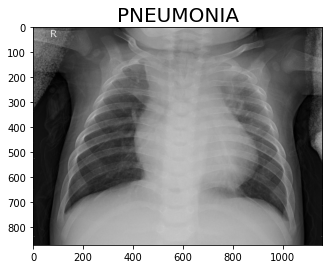

In [ ]:
plt.title('PNEUMONIA', fontsize=20)
plt.imshow(pneumonia)
print(pneumonia.shape) # print image size

(1314, 1546, 3)


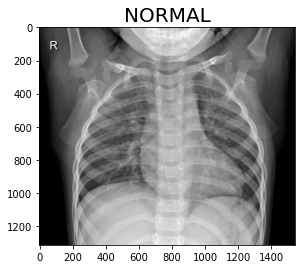

In [ ]:
plt.title('NORMAL', fontsize=20)
plt.imshow(normal)
print(normal.shape) #Print shape

Data Preprocessing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_SIZE = (227,227)
batch_size=32

train_set = datagen.flow_from_directory(train_dir,
                                        subset='training',
                                        class_mode='binary',
                                        batch_size=batch_size,
                                        classes=['NORMAL', 'PNEUMONIA'],
                                        target_size=IMG_SIZE,
                                        shuffle=True)

Found 3925 images belonging to 2 classes.


In [ ]:
valid_set = datagen.flow_from_directory(train_dir,
                                       class_mode='binary',
                                       subset='validation',
                                       batch_size=batch_size,
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=IMG_SIZE,
                                       shuffle=True)

Found 1307 images belonging to 2 classes.


In [ ]:
len(train_set)

123

In [ ]:
X_train, y_train = train_set.next()
X_test, y_test = valid_set.next()
# for X_train, y_train in train_set:
#     break
# for X_test, y_test in valid_set:
#     break


In [ ]:
len(X_train)

32

In [ ]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 227, 227, 3) Y=(32,)
Test X=(32, 227, 227, 3) Y=(32,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


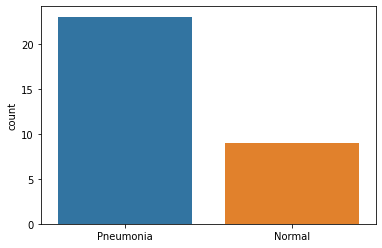

In [ ]:
labels = ['Normal' if label==0 else 'Pneumonia' for label in y_train]
sn.countplot(labels)

In [ ]:
shape = X_train[0].shape

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=2, activation='relu', input_shape=shape))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, activation='relu', kernel_size=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=32, activation='relu', kernel_size=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=64, activation='relu', kernel_size=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=128, activation='relu', kernel_size=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=256, activation='relu', kernel_size=2))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 226, 226, 8)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 113, 113, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 32)       

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpointer = ModelCheckpoint(filepath='XRAY.hdf5', verbose=1, save_best_only=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        verbose=1,
                                        factor=0.5,
                                        min_lr=0.00001)
early = EarlyStopping(monitor='val_loss',
                      patience='5',
                      restore_best_weights=True,
                      verbose=1)

In [ ]:
hist = model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[checkpointer,reduce_learning_rate,early], verbose=1)

Epoch 1/100
123/123 [==============================] - 96s 778ms/step - loss: 0.2836 - accuracy: 0.7422 - val_loss: 0.4750 - val_accuracy: 0.7422

Epoch 00001: val_loss did not improve from 0.44395
Epoch 2/100
123/123 [==============================] - 95s 775ms/step - loss: 0.2595 - accuracy: 0.7422 - val_loss: 0.2924 - val_accuracy: 0.7422

Epoch 00002: val_loss improved from 0.44395 to 0.29235, saving model to XRAY.hdf5
Epoch 3/100
123/123 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.7422